#Task 1: Learning the Basics of Keras and TensorFlow
#MLPs

In [ ]:
import tensorflow as tf
from tensorflow import keras

We will experiment with different MLPs for performing classification on datasets MNIST and Fashion MNIST. These datasets are loaded in the code cell below.

In [ ]:
from sklearn.datasets import fetch_openml
from keras.datasets import mnist
import numpy as np

num_classes = 10

# MNIST
#mnist = fetch_openml('mnist_784', version=1)
#X_mnist, y_mnist = mnist["data"], mnist["target"]
(X_train_mnist, y_train_mnist), (X_test_mnist, y_test_mnist) = mnist.load_data()
# labels are strings, so we need to cast y to integers
X_train_mnist = X_train_mnist.reshape(60000, 784)
print(X_train_mnist)
X_test_mnist = X_test_mnist.reshape(10000, 784)
X_train_mnist = X_train_mnist.astype('float32')
X_test_mnist = X_test_mnist.astype('float32')
X_train_mnist /= 255
X_test_mnist /= 255
print(X_train_mnist.shape[0], 'train samples')
print(X_test_mnist.shape[0], 'test samples')
# create train, validation, and test sets and scale the input features down to the [0,1] range
X_valid_mnist, X_train_mnist = X_train_mnist[:5000], X_train_mnist[5000:]
y_valid_mnist, y_train_mnist = y_train_mnist[:5000], y_train_mnist[5000:]
print("Shape of train set data", X_train_mnist[0].shape)
print("Datatype of train set data", X_train_mnist[0].dtype)

# Fashion MNIST
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full_fashion, y_train_full_fashion), (X_test_fashion, y_test_fashion) = fashion_mnist.load_data()
# create a validation set and scale the input features down to the [0,1] range
X_valid_fashion, X_train_fashion = X_train_full_fashion[:5000] / 255.0, X_train_full_fashion[5000:] / 255.0
y_valid_fashion, y_train_fashion = y_train_full_fashion[:5000], y_train_full_fashion[5000:]
X_test_fashion = X_test_fashion / 255.0
print("Shape of train set data", X_train_full_fashion.shape)
print("Datatype of train set data", X_train_full_fashion.dtype)

11501568/11490434 [==============================] - 0s 0us/step
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
60000 train samples
10000 test samples
Shape of train set data (784,)
Datatype of train set data float32
4431872/4422102 [==============================] - 0s 0us/step
Shape of train set data (60000, 28, 28)
Datatype of train set data uint8


Next, we're going to create a wrapper class for the reference MLP network from Aurelien Geron, "Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow", Ch. 10, pp. 297-307. This is done in order to avoid having to repeat hyperparameter values.

In [ ]:
class ReferenceMLP:


  # The default hyperparameter values correspond to the refernce network
  def __init__(self, flatten=True, kernel_initializer=None, bias_initializer=None,
               hidden_layers_activation="relu", kernel_regularizer=None,
               bias_regularizer=None, activity_regularizer=None,
               dropout_rate=None, hidden_layers_number=2,
               hidden_layers_dropout=[], hidden_layers_sizes=[300, 100]):
    
    # Create a Sequential model
    self.model = keras.models.Sequential()

    # Only Fashion MNIST needs flattening
    if flatten:
      # Convert each input into a 1D array with a Flatten layer
      self.model.add(keras.layers.Flatten(input_shape=[28,28]))

    # Add hidden layers according to the specifications
    for i in range(hidden_layers_number):
        # Some layers may be Dropout layers
        if i in hidden_layers_dropout:
          self.model.add(keras.layers.Dropout(dropout_rate))
        # All others are Dense layers
        else:
          self.model.add(keras.layers.Dense(
              hidden_layers_sizes[i],
              input_shape=(784,), 
              activation=hidden_layers_activation,
              kernel_initializer=kernel_initializer,
              bias_initializer=bias_initializer,
              kernel_regularizer=kernel_regularizer,
              bias_regularizer=bias_regularizer,
              activity_regularizer=activity_regularizer))

    # Add the output layer with 10 nodes and softmax activation
    self.model.add(keras.layers.Dense(10, activation="softmax"))


  # Compilation hyperparameters can be changed to experiment with different
  # optimization algorithms
  def compile(self, optimizer="sgd", steps_per_execution=None):
    self.model.compile(optimizer=optimizer,
                       steps_per_execution=steps_per_execution,
                       loss="sparse_categorical_crossentropy",
                       metrics=["accuracy"])
    

  # Fits the network with data from either dataset
  def fit(self, X_train, y_train, X_valid, y_valid):
    self.model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid))
    

  # Evaluates the network on the test set  
  def evaluate(self, X_test, y_test):
    return self.model.evaluate(X_test, y_test)

  # Fit and evaluate with a certain dataset (to avoid writing the same code
  # over and over)
  def fit_evaluate(self, dataset):
    if dataset=='mnist':
      self.fit(X_train_mnist, y_train_mnist, X_valid_mnist, y_valid_mnist)
      return self.evaluate(X_test_mnist, y_test_mnist)
    else:
      self.fit(X_train_fashion, y_train_fashion, X_valid_fashion,
               y_valid_fashion)
      return self.evaluate(X_test_fashion, y_test_fashion)

We need to create some lists of the hyperparameter values that we want to try. This will make it easy to parse through them in our experiments.

In [ ]:
initializers = [None, 'random_normal', 'random_uniform', 'truncated_normal', 'zeros',
                'ones']
activations = ['relu', 'sigmoid', 'tanh', 'selu', 'elu', 'exponential']
regularizers = [None, 'l1', 'l2']
optimizers = ['adadelta', 'adagrad', 'adam', 'adamax', 'ftrl', 'nadam',
              'rmsprop', 'sgd']
steps_per_executions = [None, 2, 5, 10, 20, 50, 100]

Now we iterate over these lists and observe the results.

In [ ]:
# Accuracy and loss values will be saved in these dictionaries
initializer_dict, activation_dict, regularizer_dict, optimizer_dict, steps_dict = {}, {}, {}, {}, {}

# Take each dataset in turn
for dataset in ['mnist', 'fashion']:
  print(dataset)

  #Loop over selected values for each hyperparameter
  
  for i in initializers:
    print(i)
    net = ReferenceMLP(flatten=(dataset=='fashion'), kernel_initializer=i, bias_initializer=i)
    net.compile()
    initializer_dict[(dataset, i)] = net.fit_evaluate(dataset)
    del net
  
  for i in activations:
    print(i)
    net = ReferenceMLP(flatten=(dataset=='fashion'), hidden_layers_activation=i)
    net.compile()
    activation_dict[(dataset, i)] = net.fit_evaluate(dataset)
    del net
  

  for i in regularizers:
    print(i)
    net = ReferenceMLP(flatten=(dataset=='fashion'), kernel_regularizer=i,
                       bias_regularizer=i, activity_regularizer=i)
    net.compile()
    regularizer_dict[(dataset, i)] = net.fit_evaluate(dataset)
    del net

  for i in optimizers:
    print(i)
    net = ReferenceMLP(flatten=(dataset=='fashion'))
    net.compile(optimizer=i)
    optimizer_dict[(dataset, i)] = net.fit_evaluate(dataset)
    del net

  for i in steps_per_executions:
    print(i)
    net = ReferenceMLP(flatten=(dataset=='fashion'))
    net.compile(steps_per_execution=i)
    steps_dict[(dataset, i)] = net.fit_evaluate(dataset)
    del net

mnist
None
1711/1719 [============================>.] - ETA: 0s - loss: 0.6233 - accuracy: 0.8368

KeyboardInterrupt: ignored

Time to view the results of our experiments with these hyperparameters.

In [ ]:
print("Kernel, and bias initializers: ")
print(initializer_dict)
print("Hidden layer activation functions: ")
print(activation_dict)
print("Kernel, bias, and activity regularizers: ")
print(regularizer_dict)
print("Optimizers: ")
print(optimizer_dict)
print("Steps per execution: ")
print(steps_dict)

Kernel, and bias initializers: 
{('mnist', None): [0.3114880323410034, 0.9139000177383423], ('mnist', 'random_normal'): [0.32399439811706543, 0.9097999930381775], ('mnist', 'random_uniform'): [0.35385939478874207, 0.9003000259399414], ('mnist', 'truncated_normal'): [0.3310825824737549, 0.9056000113487244], ('mnist', 'zeros'): [2.30111026763916, 0.11349999904632568], ('mnist', 'ones'): [2.3011059761047363, 0.11349999904632568], ('fashion', None): [0.5580259561538696, 0.8023999929428101], ('fashion', 'random_normal'): [0.5473095178604126, 0.8125], ('fashion', 'random_uniform'): [0.6123326420783997, 0.7879999876022339], ('fashion', 'truncated_normal'): [0.5661210417747498, 0.7997999787330627], ('fashion', 'zeros'): [2.3026182651519775, 0.10000000149011612], ('fashion', 'ones'): [2.302612543106079, 0.10000000149011612]}
Hidden layer activation functions: 
{('mnist', 'relu'): [0.3154290020465851, 0.9096999764442444], ('mnist', 'sigmoid'): [1.9444007873535156, 0.6186000108718872], ('mnist', 

Our final experiments involve changing the overall architecture of the network. This includes: changing the layers' sizes, adding or removing layers, and using Dropout layers for regularization. In the code cell below, we attempt a varied range of architectures. This experiment requires more thought than simply looping over values for a hyperparameters, so we'll manually tweak the architectures.

In [ ]:
# First, we'll observe the difference in performance after adding Dropout layers
# after every Dense layer

# Dictionary for saving the experiment results
architecture_dict = {}

# First, let's see the performance of the reference model
for dataset in ['mnist', 'fashion']:
  reference_net = ReferenceMLP(flatten=(dataset=='fashion'))
  reference_net.compile()
  architecture_dict["reference network " + dataset] = reference_net.fit_evaluate(dataset)

# Now we can add Dropout layers and see the result
for dataset in ['mnist', 'fashion']:
  do_net = ReferenceMLP(flatten=(dataset=='fashion'), dropout_rate=0.5,
                               hidden_layers_number=4, hidden_layers_dropout=[1, 3],
                               hidden_layers_sizes=[300, None, 100, None])
  do_net.compile()
  architecture_dict["reference network with dropout " + dataset] = do_net.fit_evaluate(dataset)

1645/1719 [===========================>..] - ETA: 0s - loss: 0.6387 - accuracy: 0.8349

KeyboardInterrupt: ignored

In [ ]:
# Now, we'd like to see how the layers' sizes affect the performance

# First, we decrease the sizes
for dataset in ['fashion']:
  dec_size_net = ReferenceMLP(flatten=(dataset=='fashion'),
                              hidden_layers_sizes=[100, 50])
  dec_size_net.compile()
  architecture_dict["decreased layer size network " + dataset] = dec_size_net.fit_evaluate(dataset)

# And then we increase it
for dataset in ['mnist', 'fashion']:
  inc_size_net = ReferenceMLP(flatten=(dataset=='fashion'),
                              hidden_layers_sizes=[500, 200])
  inc_size_net.compile()
  architecture_dict["increased layer size network " + dataset] = inc_size_net.fit_evaluate(dataset)

313/313 [==============================] - 1s 3ms/step - loss: 0.5487 - accuracy: 0.8093


In [ ]:
# Next, we're going to deactivate the hidden layers one at a time to see what happens

# First, we deactivate the first layer
for dataset in ['mnist', 'fashion']:
  cut_first_net = ReferenceMLP(flatten=(dataset=='fashion'), 
                              hidden_layers_number=1,
                              hidden_layers_sizes=[300])
  cut_first_net.compile()
  architecture_dict["cut first layer network " + dataset] = cut_first_net.fit_evaluate(dataset)

# And then we increase it
for dataset in ['mnist', 'fashion']:
  cut_sec_net = ReferenceMLP(flatten=(dataset=='fashion'), 
                              hidden_layers_number=1,
                              hidden_layers_sizes=[100])
  cut_sec_net.compile()
  architecture_dict["cut second layer network " + dataset] = cut_sec_net.fit_evaluate(dataset)

313/313 [==============================] - 1s 3ms/step - loss: 0.6134 - accuracy: 0.7835


In [ ]:
# Finally, the last experiment involves adding a layer in various positions

# First, add a layer in the begining
for dataset in ['mnist', 'fashion']:
  add_first_net = ReferenceMLP(flatten=(dataset=='fashion'), 
                              hidden_layers_number=3,
                              hidden_layers_sizes=[600, 300, 100])
  add_first_net.compile()
  architecture_dict["add extra first layer network " + dataset] = add_first_net.fit_evaluate(dataset)

# Add a layer at the end
for dataset in ['mnist', 'fashion']:
  add_last_net = ReferenceMLP(flatten=(dataset=='fashion'), 
                              hidden_layers_number=3,
                              hidden_layers_sizes=[300, 100, 50])
  add_last_net.compile()
  architecture_dict["add extra last layer network " + dataset] = add_last_net.fit_evaluate(dataset)

# Add a layer inbetween the existing ones
for dataset in ['mnist', 'fashion']:
  add_bet_net = ReferenceMLP(flatten=(dataset=='fashion'), 
                              hidden_layers_number=3,
                              hidden_layers_sizes=[300, 200, 100])
  add_bet_net.compile()
  architecture_dict["add extra between layer network " + dataset] = add_bet_net.fit_evaluate(dataset)

# Finally, add them all at one time, leading to a 5 hidden layer network
for dataset in ['mnist', 'fashion']:
  add_all_net = ReferenceMLP(flatten=(dataset=='fashion'), 
                              hidden_layers_number=5,
                              hidden_layers_sizes=[600, 300, 200, 100, 50])
  add_all_net.compile()
  architecture_dict["add three extra layers network " + dataset] = add_all_net.fit_evaluate(dataset)

# And add all layers with Dropout layers inbetween
for dataset in ['mnist', 'fashion']:
  add_all_net = ReferenceMLP(flatten=(dataset=='fashion'), dropout_rate=0.5,
                              hidden_layers_number=10, 
                              hidden_layers_dropout=[1, 3, 5, 7, 9],
                              hidden_layers_sizes=[600, None, 300, None, 200, None, 100, None, 50])
  add_all_net.compile()
  architecture_dict["add three extra layers with dropout network " + dataset] = add_all_net.fit_evaluate(dataset)

313/313 [==============================] - 1s 4ms/step - loss: 1.0487 - accuracy: 0.5970


The last thing to do is look at the results we obtained.

In [ ]:
print(architecture_dict)

{'add extra first layer network mnist': [0.2773894667625427, 0.921999990940094], 'add extra first layer network fashion': [0.5108171701431274, 0.8165000081062317], 'add extra last layer network mnist': [0.29255589842796326, 0.9187999963760376], 'add extra last layer network fashion': [0.5264280438423157, 0.8176000118255615], 'add extra between layer network mnist': [0.2983740270137787, 0.9136999845504761], 'add extra between layer network fashion': [0.5579094290733337, 0.800599992275238], 'add three extra layers network mnist': [0.2512660324573517, 0.9273999929428101], 'add three extra layers network fashion': [0.5601330399513245, 0.7968999743461609], 'add three extra layers with dropout network mnist': [1.477492332458496, 0.46639999747276306], 'add three extra layers with dropout network fashion': [1.0486695766448975, 0.597000002861023]}


#CNNs

In [ ]:
#defining and preprocessing mnist and fashion mnist data here

#MNIST
mnist = keras.datasets.mnist
(mnist_X_train_full, mnist_y_train_full), (mnist_X_test, mnist_y_test) = mnist.load_data()
mnist_X_valid, mnist_X_train = mnist_X_train_full[:5000] / 255.0, mnist_X_train_full[5000:] / 255.0
mnist_y_valid, mnist_y_train = mnist_y_train_full[:5000], mnist_y_train_full[5000:]

#adding single channel of grayscale to CNN input
mnist_X_train = mnist_X_train.reshape((mnist_X_train.shape[0], 28, 28, 1))
mnist_X_test = mnist_X_test.reshape((mnist_X_test.shape[0], 28, 28, 1))
mnist_X_valid = mnist_X_valid.reshape((mnist_X_valid.shape[0], 28, 28, 1))

#since the taget value is an integer, using one hot encode target values as binary vactor with 1 in target index and 0 elsewhere
#target vectors of size 10 for the 10 categories
mnist_y_train = np_utils.to_categorical(mnist_y_train)
mnist_y_test = np_utils.to_categorical(mnist_y_test)
mnist_y_valid = np_utils.to_categorical(mnist_y_valid)

#FASHION MNIST

fashion_mnist = keras.datasets.fashion_mnist
(fashion_mnist_X_train_full, fashion_mnist_y_train_full), (fashion_mnist_X_test, fashion_mnist_y_test) = fashion_mnist.load_data()
fashion_mnist_X_valid, fashion_mnist_X_train = fashion_mnist_X_train_full[:5000] / 255.0, fashion_mnist_X_train_full[5000:] / 255.0
fashion_mnist_y_valid, fashion_mnist_y_train = fashion_mnist_y_train_full[:5000], fashion_mnist_y_train_full[5000:]

#adding single channel of grayscale to CNN input
fashion_mnist_X_train = fashion_mnist_X_train.reshape((fashion_mnist_X_train.shape[0], 28, 28, 1))
fashion_mnist_X_test = fashion_mnist_X_test.reshape((fashion_mnist_X_test.shape[0], 28, 28, 1))
fashion_mnist_X_valid = fashion_mnist_X_valid.reshape((fashion_mnist_X_valid.shape[0], 28, 28, 1))
 
#since the taget value is an integer, using one hot encode target values as binary vactor with 1 in target index and 0 elsewhere
#target vectors of size 10 for the 10 categories
fashion_mnist_y_train = np_utils.to_categorical(fashion_mnist_y_train)
fashion_mnist_y_test = np_utils.to_categorical(fashion_mnist_y_test)
fashion_mnist_y_valid = np_utils.to_categorical(fashion_mnist_y_valid)

4431872/4422102 [==============================] - 0s 0us/step


<h3> Tuning Hyperparameters that do not change the network</h3>

In [ ]:
from functools import partial
def define_model(optimizer='adam'):
  DefaultConv2D = partial(keras.layers.Conv2D,
  kernel_size=3, activation='relu', padding="SAME")
  model = keras.models.Sequential([
  DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
  keras.layers.MaxPooling2D(pool_size=2),
  DefaultConv2D(filters=128),
  DefaultConv2D(filters=128),
  keras.layers.MaxPooling2D(pool_size=2),
  DefaultConv2D(filters=256),
  DefaultConv2D(filters=256),
  keras.layers.MaxPooling2D(pool_size=2),
  keras.layers.Flatten(),
  keras.layers.Dense(units=128, activation='relu'),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(units=64, activation='relu'),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(units=10, activation='softmax'),
  ])
  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return model

In [ ]:
sgd1=keras.optimizers.SGD(learning_rate=0.001)
sgd2=keras.optimizers.SGD(learning_rate=0.01)
sgd3=keras.optimizers.SGD(learning_rate=0.1)
adagrad1=keras.optimizers.Adagrad(learning_rate=0.001)
adagrad2=keras.optimizers.Adagrad(learning_rate=0.01)
adagrad3=keras.optimizers.Adagrad(learning_rate=0.1)
adam1=keras.optimizers.Adam(learning_rate=0.001)
adam2=keras.optimizers.Adam(learning_rate=0.01)
adam3=keras.optimizers.Adam(learning_rate=0.1)
rmsprop1=keras.optimizers.RMSprop(learning_rate=0.001)
rmsprop2=keras.optimizers.RMSprop(learning_rate=0.001)
rmsprop3=keras.optimizers.RMSprop(learning_rate=0.001)
optimizer=[sgd1, sgd2, sgd3, adagrad1, adagrad2, adagrad3, adam1, adam2, adam3, rmsprop1, rmsprop2, rmsprop3]

In [ ]:
optimizer_dict={}
for dataset in ['mnist', 'fashion']:
 for i in optimizer:
  model=define_model(i)
  if(dataset=='mnist'):
    model.fit(mnist_X_train, mnist_y_train, validation_data=(mnist_X_valid, mnist_y_valid))
    score, acc = model.evaluate(mnist_X_test, mnist_y_test, verbose=0)
  else:
    model.fit(fashion_mnist_X_train, fashion_mnist_y_train, validation_data=(fashion_mnist_X_valid,fashion_mnist_y_valid))
    score, acc = model.evaluate(fashion_mnist_X_test, fashion_mnist_y_test, verbose=0)
  print('Val accuracy:', acc)
  optimizer_dict[(dataset,i)]=acc

print(optimizer_dict)
#MNIST - 98.86 accuracy --> RMSprop LR=0.01
#Fashion MNIST - 85.57 --> RMSprop LR=0.1

batch_size=[64,128,256]
epochs=[5,10]
epochs_bs_dict={}
for dataset in ['mnist', 'fashion']:
 for i in batch_size:
   for j in epochs:
    if(dataset=='mnist'):
      model=define_model(rmsprop2)
      model.fit(mnist_X_train, mnist_y_train, epochs=j, batch_size=i, validation_data=(mnist_X_valid, mnist_y_valid))
      score, acc = model.evaluate(mnist_X_test, mnist_y_test, verbose=0)
    else:
      model=define_model(rmsprop3)
      model.fit(fashion_mnist_X_train, fashion_mnist_y_train, epochs=j, batch_size=i, validation_data=(fashion_mnist_X_valid,fashion_mnist_y_valid))
      score, acc = model.evaluate(fashion_mnist_X_test, fashion_mnist_y_test, verbose=0)
    print('Val accuracy:', acc)
    optimizer_dict[(dataset,"bs "+str(i)+" ep "+str(j))]=acc

print(optimizer_dict)
#MNIST - 99.39 --> bs 256 ep 10
#fashion - 90.11 --> bs 256 ep 10

In [ ]:
from functools import partial
def define_model2(optimizer='adam', kernel_initializer='glorot_uniform', bias_initializer='zeros'):
  DefaultConv2D = partial(keras.layers.Conv2D,
  kernel_size=3, activation='relu', padding="SAME", kernel_initializer=kernel_initializer, bias_initializer=bias_initializer)
  model = keras.models.Sequential([
  DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
  keras.layers.MaxPooling2D(pool_size=2),
  DefaultConv2D(filters=128),
  DefaultConv2D(filters=128),
  keras.layers.MaxPooling2D(pool_size=2),
  DefaultConv2D(filters=256),
  DefaultConv2D(filters=256),
  keras.layers.MaxPooling2D(pool_size=2),
  keras.layers.Flatten(),
  keras.layers.Dense(units=128, activation='relu'),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(units=64, activation='relu'),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(units=10, activation='softmax'),
  ])
  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return model

In [ ]:
w1_randomNormal=tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
w2_zeros=tf.keras.initializers.Zeros()
w3_glorotUniform=tf.keras.initializers.GlorotUniform()
weights=[w1_randomNormal,w2_zeros,w3_glorotUniform]
epochs_bs_dict={}
for dataset in ['mnist', 'fashion']:
 for i in weights:
   for j in weights:
    if(dataset=='mnist'):
      model=define_model2(rmsprop2, kernel_initializer=i, bias_initializer=j)
      model.fit(mnist_X_train, mnist_y_train, epochs=10, batch_size=256, validation_data=(mnist_X_valid, mnist_y_valid))
      score, acc = model.evaluate(mnist_X_test, mnist_y_test, verbose=0)
    else:
      model=define_model2(rmsprop3, kernel_initializer=i, bias_initializer=j)
      model.fit(fashion_mnist_X_train, fashion_mnist_y_train, epochs=10, batch_size=256, validation_data=(fashion_mnist_X_valid,fashion_mnist_y_valid))
      score, acc = model.evaluate(fashion_mnist_X_test, fashion_mnist_y_test, verbose=0)
    print('Val accuracy:', acc)
    optimizer_dict[(dataset,"kernel "+str(i)+" bias "+str(j))]=acc

print(optimizer_dict)

<h3> Tuning Parameters that change the network </h3>

In [ ]:
from functools import partial
def define_model3(optimizer='adam', default_kernel_size=3,
                  activation='relu', padding='SAME',filter_one=64, filter_two=128, filter_three=256, dense_units_one=128, 
                  dense_units_two=64, dropout_rate=0.5):
  DefaultConv2D = partial(keras.layers.Conv2D,
  kernel_size=default_kernel_size, activation=activation, padding="SAME")
  model = keras.models.Sequential([
  DefaultConv2D(filters=filter_one, kernel_size=7, input_shape=[28, 28, 1]),
  keras.layers.MaxPooling2D(pool_size=2),
  DefaultConv2D(filters=filter_two),
  DefaultConv2D(filters=filter_two),
  keras.layers.MaxPooling2D(pool_size=2),
  DefaultConv2D(filters=filter_three),
  DefaultConv2D(filters=filter_three),
  keras.layers.MaxPooling2D(pool_size=2),
  keras.layers.Flatten(),
  keras.layers.Dense(units=dense_units_one, activation=activation),
  keras.layers.Dropout(dropout_rate),
  keras.layers.Dense(units=dense_units_two, activation=activation),
  keras.layers.Dropout(dropout_rate),
  keras.layers.Dense(units=10, activation='softmax'),
  ])
  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy']) 
  return model

In [ ]:
#changing activation function 
activation_dictionary={}
for dataset in ['mnist', 'fashion']:
  for i in ['tanh','selu']:
     if(dataset=='mnist'):
      model=define_model3(optimizer=rmsprop2, activation=i)
      model.fit(mnist_X_train, mnist_y_train, epochs=10, batch_size=256, validation_data=(mnist_X_valid, mnist_y_valid))
      score, acc = model.evaluate(mnist_X_test, mnist_y_test, verbose=0)
     else:
      model=define_model3(optimizer=rmsprop3, activation=i)
      model.fit(fashion_mnist_X_train, fashion_mnist_y_train, epochs=10, batch_size=256, validation_data=(fashion_mnist_X_valid,fashion_mnist_y_valid))
      score, acc = model.evaluate(fashion_mnist_X_test, fashion_mnist_y_test, verbose=0)
     print('Val accuracy:', acc)
     activation_dictionary[(dataset,i)]=acc

print(activation_dictionary)

#changing filter sizes
#reducing
filter_decrease_dictionary={}
for dataset in ['mnist', 'fashion']:
     if(dataset=='mnist'):
      model=define_model3(optimizer=rmsprop2, filter_one=16, filter_two=64, filter_three=128, dense_units_one=64, dense_units_two=16)
      model.fit(mnist_X_train, mnist_y_train, epochs=10, batch_size=256, validation_data=(mnist_X_valid, mnist_y_valid))
      score, acc = model.evaluate(mnist_X_test, mnist_y_test, verbose=0)
     else:
      model=define_model3(optimizer=rmsprop3, filter_one=16, filter_two=64, filter_three=128, dense_units_one=64, dense_units_two=16)
      model.fit(fashion_mnist_X_train, fashion_mnist_y_train, epochs=10, batch_size=256, validation_data=(fashion_mnist_X_valid,fashion_mnist_y_valid))
      score, acc = model.evaluate(fashion_mnist_X_test, fashion_mnist_y_test, verbose=0)
     print('Val accuracy:', acc)
     filter_decrease_dictionary[(dataset,i)]=acc

#increasing
filter_increase_dictionary={}
for dataset in ['mnist', 'fashion']:
     if(dataset=='mnist'):
      model=define_model3(optimizer=rmsprop2, filter_one=128, filter_two=256, filter_three=512, dense_units_one=256, dense_units_two=128)
      model.fit(mnist_X_train, mnist_y_train, epochs=10, batch_size=256, validation_data=(mnist_X_valid, mnist_y_valid))
      score, acc = model.evaluate(mnist_X_test, mnist_y_test, verbose=0)
     else:
      model=define_model3(optimizer=rmsprop3, filter_one=128, filter_two=256, filter_three=512, dense_units_one=256, dense_units_two=128)
      model.fit(fashion_mnist_X_train, fashion_mnist_y_train, epochs=10, batch_size=256, validation_data=(fashion_mnist_X_valid,fashion_mnist_y_valid))
      score, acc = model.evaluate(fashion_mnist_X_test, fashion_mnist_y_test, verbose=0)
     print('Val accuracy:', acc)
     filter_increase_dictionary[(dataset,i)]=acc

print(filter_decrease_dictionary)
print(filter_increase_dictionary)


dropout_rate_dictionary={}
for dataset in ['mnist', 'fashion']:
     if(dataset=='mnist'):
      model=define_model3(optimizer=rmsprop2, dropout_rate=0.4)
      model.fit(mnist_X_train, mnist_y_train, epochs=10, batch_size=256, validation_data=(mnist_X_valid, mnist_y_valid))
      score, acc = model.evaluate(mnist_X_test, mnist_y_test, verbose=0)
     else:
      model=define_model3(optimizer=rmsprop3, dropout_rate=0.4)
      model.fit(fashion_mnist_X_train, fashion_mnist_y_train, epochs=10, batch_size=256, validation_data=(fashion_mnist_X_valid,fashion_mnist_y_valid))
      score, acc = model.evaluate(fashion_mnist_X_test, fashion_mnist_y_test, verbose=0)
     print('Val accuracy:', acc)
     dropout_rate_dictionary[(dataset)]=acc

print(dropout_rate_dictionary)


In [ ]:
from functools import partial

pool_dictionary={}

DefaultConv2D = partial(keras.layers.Conv2D,
  kernel_size=3, activation='relu', padding="SAME")
model_pool = keras.models.Sequential([
  DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
  keras.layers.AveragePooling2D(pool_size=2),
  DefaultConv2D(filters=128),
  DefaultConv2D(filters=128),
  keras.layers.AveragePooling2D(pool_size=2),
  DefaultConv2D(filters=256),
  DefaultConv2D(filters=256),
  keras.layers.AveragePooling2D(pool_size=2),
  keras.layers.Flatten(),
  keras.layers.Dense(units=128, activation='relu'),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(units=64, activation='relu'),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(units=10, activation='softmax'),
  ])
model_pool.compile(loss='categorical_crossentropy', optimizer=rmsprop2, metrics=['accuracy'])
model_pool.fit(mnist_X_train, mnist_y_train, epochs=10, batch_size=256, validation_data=(mnist_X_valid, mnist_y_valid))
score, acc = model_pool.evaluate(mnist_X_test, mnist_y_test, verbose=0)
pool_dictionary['mnist']=acc

model_pool.compile(loss='categorical_crossentropy', optimizer=rmsprop3, metrics=['accuracy'])
model_pool.fit(fashion_mnist_X_train, fashion_mnist_y_train, epochs=10, batch_size=256, validation_data=(fashion_mnist_X_valid,fashion_mnist_y_valid))
score, acc = model_pool.evaluate(fashion_mnist_X_test, fashion_mnist_y_test, verbose=0)
pool_dictionary['fashion']=acc

print(pool_dictionary)

In [ ]:
layers_reduce_dictionary={}
DefaultConv2D = partial(keras.layers.Conv2D,
  kernel_size=3, activation='relu', padding="SAME")
model_layer_reduce = keras.models.Sequential([
  DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
  keras.layers.MaxPooling2D(pool_size=2),
  DefaultConv2D(filters=128),
  DefaultConv2D(filters=128),
  keras.layers.MaxPooling2D(pool_size=2),
  keras.layers.Flatten(),
  keras.layers.Dense(units=128, activation='relu'),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(units=64, activation='relu'),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(units=10, activation='softmax'),
  ])
model_layer_reduce.compile(loss='categorical_crossentropy', optimizer=rmsprop2, metrics=['accuracy'])
model_layer_reduce.fit(mnist_X_train, mnist_y_train, epochs=10, batch_size=256, validation_data=(mnist_X_valid, mnist_y_valid))
score, acc = model_layer_reduce.evaluate(mnist_X_test, mnist_y_test, verbose=0)
layers_reduce_dictionary['mnist']=acc

model_layer_reduce.compile(loss='categorical_crossentropy', optimizer=rmsprop3, metrics=['accuracy'])
model_layer_reduce.fit(fashion_mnist_X_train, fashion_mnist_y_train, epochs=10, batch_size=256, validation_data=(fashion_mnist_X_valid,fashion_mnist_y_valid))
score, acc = model_layer_reduce.evaluate(fashion_mnist_X_test, fashion_mnist_y_test, verbose=0)
layers_reduce_dictionary['fashion']=acc

print(layers_reduce_dictionary)

In [ ]:
layers_increase_dictionary={}
DefaultConv2D = partial(keras.layers.Conv2D,
  kernel_size=3, activation='relu', padding="SAME")
model_layer_increase = keras.models.Sequential([
  DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
  keras.layers.MaxPooling2D(pool_size=2),
  DefaultConv2D(filters=128),
  DefaultConv2D(filters=128),
  keras.layers.MaxPooling2D(pool_size=2),
  DefaultConv2D(filters=256),
  DefaultConv2D(filters=256),
  keras.layers.MaxPooling2D(pool_size=2),
  DefaultConv2D(filters=512),
  DefaultConv2D(filters=512),
  keras.layers.MaxPooling2D(pool_size=2),
  keras.layers.Flatten(),
  keras.layers.Dense(units=128, activation='relu'),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(units=64, activation='relu'),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(units=10, activation='softmax'),
  ])
model_layer_increase.compile(loss='categorical_crossentropy', optimizer=rmsprop2, metrics=['accuracy'])
model_layer_increase.fit(mnist_X_train, mnist_y_train, epochs=10, batch_size=256, validation_data=(mnist_X_valid, mnist_y_valid))
score, acc = model_layer_increase.evaluate(mnist_X_test, mnist_y_test, verbose=0)
layers_increase_dictionary['mnist']=acc

model_layer_increase.compile(loss='categorical_crossentropy', optimizer=rmsprop3, metrics=['accuracy'])
model_layer_increase.fit(fashion_mnist_X_train, fashion_mnist_y_train, epochs=10, batch_size=256, validation_data=(fashion_mnist_X_valid,fashion_mnist_y_valid))
score, acc = model_layer_increase.evaluate(fashion_mnist_X_test, fashion_mnist_y_test, verbose=0)
layers_increase_dictionary['fashion']=acc

print(layers_increase_dictionary)

#Task 2: Testing the Impact of Obfuscating Data by Randomly Permuting All Pixels
To start with, we're going to apply a simple permutation of the pixel rows in the images in both datasets.

In [ ]:
import numpy as np

# Generating a random state
rand = np.random.RandomState()

perm_mnist = rand.permutation(X_train_mnist.shape[1])
X_train_mnist_perm = X_train_mnist[:, perm_mnist]
X_valid_mnist_perm = X_valid_mnist[:, perm_mnist]
X_test_mnist_perm = X_test_mnist[:, perm_mnist]

perm_fashion = rand.permutation(X_train_fashion.shape[1])
X_train_fashion_perm = X_train_fashion[:, perm_fashion]
X_valid_fashion_perm = X_valid_fashion[:, perm_fashion]
X_test_fashion_perm = X_test_fashion[:, perm_fashion]

'\ny_train_mnist = y_train_mnist.T\ny_valid_mnist = y_valid_mnist.T\ny_test_mnist = y_test_mnist.T\ny_train_fashion = y_train_fashion.T\ny_valid_fashion = y_valid_fashion.T\ny_test_fashion = y_test_fashion.T\n\n# Obfuscating MNIST\nX_train_mnist_perm = obfuscate(X_train_mnist, rand)\nX_valid_mnist_perm = obfuscate(X_valid_mnist, rand)\nX_test_mnist_perm = obfuscate(X_test_mnist, rand)\n\n# Obfuscating Fashion MNIST\nX_train_fashion_perm = obfuscate(X_train_fashion, rand)\nX_valid_fashion_perm = obfuscate(X_valid_fashion, rand)\nX_test_fashion_perm = obfuscate(X_test_fashion, rand)\n'

Let's take a look at what a Fashion MNIST sample looks like before and after obfuscation.

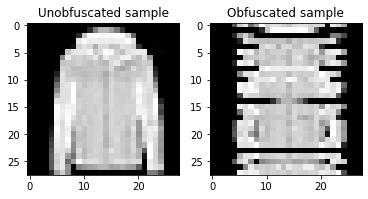

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(1, 2)
ax1 = axes[0]
ax1.imshow(X_train_fashion[0], cmap='gray')
ax1.set_title('Unobfuscated sample')
ax2 = axes[1]
ax2.imshow(X_train_fashion_perm[0], cmap='gray')
ax2.set_title('Obfuscated sample')
plt.show()

#MLPs
Now, we can get started with the MLPs. We will combine the best observed hyperparamater values and architectures from Task 1 to obtain the 'ideal' network for each dataset. For MNIST we will use: no initializer, SELU activation, no regularization, NAdam optimization, 10 steps per execution, and an additional layer between the existing layers in the reference network. For Fashion MNIST: random normal initialization, SELU activation, L2 regularization, NAdam optimization, 20 steps per execution, and 3 additional layers.

In [ ]:
# Creating the 'ideal' MLP for MNIST
model_mnist = keras.models.Sequential()
model_mnist.add(keras.layers.Dense(300, input_shape=(784,), activation='selu'))
model_mnist.add(keras.layers.Dense(200, activation='selu'))
model_mnist.add(keras.layers.Dense(100, activation='selu'))
model_mnist.add(keras.layers.Dense(10, activation="softmax"))
model_mnist.compile(optimizer='nadam', steps_per_execution=10,
                   loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Creating an identical MLP for obfuscated MNIST
model_mnist_perm = keras.models.Sequential()
model_mnist_perm.add(keras.layers.Dense(300, input_shape=(784,), activation='selu'))
model_mnist_perm.add(keras.layers.Dense(200, activation='selu'))
model_mnist_perm.add(keras.layers.Dense(100, activation='selu'))
model_mnist_perm.add(keras.layers.Dense(10, activation="softmax"))
model_mnist_perm.compile(optimizer='nadam', steps_per_execution=10,
                   loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Creating the 'ideal' MLP for Fashion MNIST
model_fashion = keras.models.Sequential()
model_fashion.add(keras.layers.Flatten(input_shape=[28,28]))
model_fashion.add(keras.layers.Dense(600, input_shape=(784,), activation='selu',
                                   kernel_initializer='random_normal',
                                   bias_initializer='random_normal',
                                   kernel_regularizer='l2',
                                   bias_regularizer='l2',
                                   activity_regularizer='l2'))
model_fashion.add(keras.layers.Dense(300, activation='selu',
                                   kernel_initializer='random_normal',
                                   bias_initializer='random_normal',
                                   kernel_regularizer='l2',
                                   bias_regularizer='l2',
                                   activity_regularizer='l2'))
model_fashion.add(keras.layers.Dense(200, activation='selu',
                                   kernel_initializer='random_normal',
                                   bias_initializer='random_normal',
                                   kernel_regularizer='l2',
                                   bias_regularizer='l2',
                                   activity_regularizer='l2'))
model_fashion.add(keras.layers.Dense(100, activation='selu',
                                   kernel_initializer='random_normal',
                                   bias_initializer='random_normal',
                                   kernel_regularizer='l2',
                                   bias_regularizer='l2',
                                   activity_regularizer='l2'))
model_fashion.add(keras.layers.Dense(50, activation='selu',
                                   kernel_initializer='random_normal',
                                   bias_initializer='random_normal',
                                   kernel_regularizer='l2',
                                   bias_regularizer='l2',
                                   activity_regularizer='l2'))
model_fashion.add(keras.layers.Dense(10, activation="softmax"))
model_fashion.compile(optimizer='nadam', steps_per_execution=20,
                   loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Creating an identical MLP for the obfuscated Fashion MNIST
model_fashion_perm = keras.models.Sequential()
model_fashion_perm.add(keras.layers.Flatten(input_shape=[28,28]))
model_fashion_perm.add(keras.layers.Dense(600, input_shape=(784,), activation='selu',
                                   kernel_initializer='random_normal',
                                   bias_initializer='random_normal',
                                   kernel_regularizer='l2',
                                   bias_regularizer='l2',
                                   activity_regularizer='l2'))
model_fashion_perm.add(keras.layers.Dense(300, activation='selu',
                                   kernel_initializer='random_normal',
                                   bias_initializer='random_normal',
                                   kernel_regularizer='l2',
                                   bias_regularizer='l2',
                                   activity_regularizer='l2'))
model_fashion_perm.add(keras.layers.Dense(200, activation='selu',
                                   kernel_initializer='random_normal',
                                   bias_initializer='random_normal',
                                   kernel_regularizer='l2',
                                   bias_regularizer='l2',
                                   activity_regularizer='l2'))
model_fashion_perm.add(keras.layers.Dense(100, activation='selu',
                                   kernel_initializer='random_normal',
                                   bias_initializer='random_normal',
                                   kernel_regularizer='l2',
                                   bias_regularizer='l2',
                                   activity_regularizer='l2'))
model_fashion_perm.add(keras.layers.Dense(50, activation='selu',
                                   kernel_initializer='random_normal',
                                   bias_initializer='random_normal',
                                   kernel_regularizer='l2',
                                   bias_regularizer='l2',
                                   activity_regularizer='l2'))
model_fashion_perm.add(keras.layers.Dense(10, activation="softmax"))
model_fashion_perm.compile(optimizer='nadam', steps_per_execution=20,
                   loss="sparse_categorical_crossentropy", metrics=["accuracy"])

Now, let's see how how the same network performs when trained on unobfuscated vs. obfuscated datasets.

In [ ]:
print("X_train_mnist", X_train_mnist)
print("shape X_train", X_train_fashion[0].shape)
print("y_train_mnist", y_train_mnist)
print("shape X_train_perm", X_train_fashion_perm[0].shape)
#print("X_train_mnist_perm", X_train_mnist_perm)
print("y_train_mnist", y_train_mnist)
print(len(X_train_mnist))

# Unobfuscated MNIST
print("Unobfuscated MNIST")
model_mnist.fit(X_train_mnist, y_train_mnist, epochs=1,
               validation_data=(X_valid_mnist, y_valid_mnist))
model_mnist.evaluate(X_test_mnist, y_test_mnist)

# Obfuscated MNIST
print("Obfuscated MNIST")
model_mnist_perm.fit(X_train_mnist_perm, y_train_mnist, epochs=1,
               validation_data=(X_valid_mnist_perm, y_valid_mnist))
model_mnist_perm.evaluate(X_test_mnist_perm, y_test_mnist)

# Unobfuscated Fashion MNIST
print("Unobfuscated Fashion MNIST")
model_fashion.fit(X_train_fashion, y_train_fashion, epochs=1,
               validation_data=(X_valid_fashion, y_valid_fashion))
model_fashion.evaluate(X_test_fashion, y_test_fashion)

# Obfuscated Fashion MNIST
print("Obfuscated Fashion MNIST")
model_fashion_perm.fit(X_train_fashion_perm, y_train_fashion, epochs=1,
               validation_data=(X_valid_fashion_perm, y_valid_fashion))
model_fashion_perm.evaluate(X_test_fashion_perm, y_test_fashion)

X_train_mnist [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
shape X_train (28, 28)
y_train_mnist [7 3 4 ... 5 6 8]
shape X_train_perm (28, 28)
y_train_mnist [7 3 4 ... 5 6 8]
55000
Unobfuscated MNIST
313/313 [==============================] - 1s 2ms/step - loss: 0.1569 - accuracy: 0.9516
Obfuscated MNIST
313/313 [==============================] - 1s 2ms/step - loss: 0.1277 - accuracy: 0.9623
Unobfuscated Fashion MNIST
313/313 [==============================] - 1s 4ms/step - loss: 1.0237 - accuracy: 0.7898
Obfuscated Fashion MNIST
313/313 [==============================] - 1s 3ms/step - loss: 1.3610 - accuracy: 0.7789


[1.3609613180160522, 0.7789000272750854]

#CNNs

In [ ]:
#Creating the 'ideal' CNN for MNIST dataset using hyperparameter learnt in previous task
from functools import partial

#dropout_rate=0.4, Optimizer=RMSprop(learning_rate=0.001), epochs=10, batch_size=256
DefaultConv2D = partial(keras.layers.Conv2D,
  kernel_size=3, activation='relu', padding="SAME")
mnist_model = keras.models.Sequential([
  DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
  keras.layers.MaxPooling2D(pool_size=2),
  DefaultConv2D(filters=128),
  DefaultConv2D(filters=128),
  keras.layers.MaxPooling2D(pool_size=2),
  DefaultConv2D(filters=256),
  DefaultConv2D(filters=256),
  keras.layers.MaxPooling2D(pool_size=2),
  keras.layers.Flatten(),
  keras.layers.Dense(units=128, activation='relu'),
  keras.layers.Dropout(0.4),
  keras.layers.Dense(units=64, activation='relu'),
  keras.layers.Dropout(0.4),
  keras.layers.Dense(units=10, activation='softmax'),
  ])
mnist_model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(learning_rate=0.001), metrics=['accuracy'])
mnist_model.fit(mnist_X_train, mnist_y_train, epochs=10, batch_size=256, validation_data=(mnist_X_valid, mnist_y_valid))
score, acc = mnist_model.evaluate(mnist_X_test, mnist_y_test, verbose=0)

Epoch 1/10


KeyboardInterrupt: ignored

In [ ]:
from functools import partial

#dropout_rate=0.4, Optimizer=RMSprop(learning_rate=0.001), epochs=10, batch_size=256
DefaultConv2D = partial(keras.layers.Conv2D,
  kernel_size=3, activation='relu', padding="SAME")
mnist_model = keras.models.Sequential([
  DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
  keras.layers.MaxPooling2D(pool_size=2),
  DefaultConv2D(filters=128),
  DefaultConv2D(filters=128),
  keras.layers.MaxPooling2D(pool_size=2),
  DefaultConv2D(filters=256),
  DefaultConv2D(filters=256),
  keras.layers.MaxPooling2D(pool_size=2),
  keras.layers.Flatten(),
  keras.layers.Dense(units=128, activation='relu'),
  keras.layers.Dropout(0.4),
  keras.layers.Dense(units=64, activation='relu'),
  keras.layers.Dropout(0.4),
  keras.layers.Dense(units=10, activation='softmax'),
  ])
mnist_model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(learning_rate=0.001), metrics=['accuracy'])
#mnist_model.fit(mnist_X_train, mnist_y_train, epochs=10, batch_size=256, validation_data=(mnist_X_valid, mnist_y_valid))
#score, acc = mnist_model.evaluate(mnist_X_test, mnist_y_test, verbose=0)


DefaultConv2D = partial(keras.layers.Conv2D,
  kernel_size=3, activation='relu', padding="SAME")
permuted_mnist_model = keras.models.Sequential([
  DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
  keras.layers.MaxPooling2D(pool_size=2),
  DefaultConv2D(filters=128),
  DefaultConv2D(filters=128),
  keras.layers.MaxPooling2D(pool_size=2),
  DefaultConv2D(filters=256),
  DefaultConv2D(filters=256),
  keras.layers.MaxPooling2D(pool_size=2),
  keras.layers.Flatten(),
  keras.layers.Dense(units=128, activation='relu'),
  keras.layers.Dropout(0.4),
  keras.layers.Dense(units=64, activation='relu'),
  keras.layers.Dropout(0.4),
  keras.layers.Dense(units=10, activation='softmax'),
  ])
permuted_mnist_model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(learning_rate=0.001), metrics=['accuracy'])

In [ ]:
#dropout_rate=0.5, Optimizer=RMSprop(learning_rate=0.001), epochs=10, batch_size=256
DefaultConv2D = partial(keras.layers.Conv2D,
  kernel_size=3, activation='relu', padding="SAME")
fashion_mnist_model = keras.models.Sequential([
  DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
  keras.layers.MaxPooling2D(pool_size=2),
  DefaultConv2D(filters=128),
  DefaultConv2D(filters=128),
  keras.layers.MaxPooling2D(pool_size=2),
  DefaultConv2D(filters=256),
  DefaultConv2D(filters=256),
  keras.layers.MaxPooling2D(pool_size=2),
  keras.layers.Flatten(),
  keras.layers.Dense(units=128, activation='relu'),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(units=64, activation='relu'),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(units=10, activation='softmax'),
  ])
fashion_mnist_model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(learning_rate=0.001), metrics=['accuracy'])
#fashion_mnist_model.fit(fashion_mnist_X_train, fashion_mnist_y_train, epochs=10, batch_size=256, validation_data=(fashion_mnist_X_valid, fashion_mnist_y_valid))
#score, acc = fashion_mnist_model.evaluate(fashion_mnist_X_test, fashion_mnist_y_test, verbose=0)

permuted_fashion_mnist_model = keras.models.Sequential([
  DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
  keras.layers.MaxPooling2D(pool_size=2),
  DefaultConv2D(filters=128),
  DefaultConv2D(filters=128),
  keras.layers.MaxPooling2D(pool_size=2),
  DefaultConv2D(filters=256),
  DefaultConv2D(filters=256),
  keras.layers.MaxPooling2D(pool_size=2),
  keras.layers.Flatten(),
  keras.layers.Dense(units=128, activation='relu'),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(units=64, activation='relu'),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(units=10, activation='softmax'),
  ])
permuted_fashion_mnist_model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(learning_rate=0.001), metrics=['accuracy'])

In [ ]:
mnist_model.fit(mnist_X_train, mnist_y_train, epochs=10, batch_size=256, validation_data=(mnist_X_valid, mnist_y_valid))
mnist_model.evaluate(mnist_X_test, mnist_y_test, verbose=0)

Epoch 1/10
215/215 [==============================] - 14s 61ms/step - loss: 0.6340 - accuracy: 0.7941 - val_loss: 0.0695 - val_accuracy: 0.9812
Epoch 2/10
215/215 [==============================] - 13s 60ms/step - loss: 0.1098 - accuracy: 0.9724 - val_loss: 0.1523 - val_accuracy: 0.9642
Epoch 3/10
215/215 [==============================] - 13s 60ms/step - loss: 0.0660 - accuracy: 0.9832 - val_loss: 0.0440 - val_accuracy: 0.9922
Epoch 4/10
215/215 [==============================] - 13s 61ms/step - loss: 0.0510 - accuracy: 0.9879 - val_loss: 0.0407 - val_accuracy: 0.9896
Epoch 5/10
215/215 [==============================] - 13s 60ms/step - loss: 0.0374 - accuracy: 0.9912 - val_loss: 0.0408 - val_accuracy: 0.9908
Epoch 6/10
215/215 [==============================] - 13s 60ms/step - loss: 0.0330 - accuracy: 0.9921 - val_loss: 0.0392 - val_accuracy: 0.9904
Epoch 7/10
215/215 [==============================] - 13s 60ms/step - loss: 0.0275 - accuracy: 0.9937 - val_loss: 0.0354 - val_accuracy:

[7.644179821014404, 0.9940000176429749]

In [ ]:
permuted_mnist_model.fit(permuted_mnist_X_train, mnist_y_train, epochs=10, batch_size=256, validation_data=(permuted_mnist_X_valid, mnist_y_valid))
permuted_mnist_model.evaluate(permuted_mnist_X_test, mnist_y_test, verbose=0)

Epoch 1/10
215/215 [==============================] - 14s 62ms/step - loss: 0.9532 - accuracy: 0.6751 - val_loss: 0.2243 - val_accuracy: 0.9376
Epoch 2/10
215/215 [==============================] - 13s 61ms/step - loss: 0.1991 - accuracy: 0.9477 - val_loss: 0.1007 - val_accuracy: 0.9726
Epoch 3/10
215/215 [==============================] - 13s 62ms/step - loss: 0.1236 - accuracy: 0.9685 - val_loss: 0.0798 - val_accuracy: 0.9770
Epoch 4/10
215/215 [==============================] - 13s 61ms/step - loss: 0.0855 - accuracy: 0.9781 - val_loss: 0.0741 - val_accuracy: 0.9802
Epoch 5/10
215/215 [==============================] - 13s 61ms/step - loss: 0.0686 - accuracy: 0.9825 - val_loss: 0.0994 - val_accuracy: 0.9786
Epoch 6/10
215/215 [==============================] - 13s 61ms/step - loss: 0.0541 - accuracy: 0.9863 - val_loss: 0.0855 - val_accuracy: 0.9818
Epoch 7/10
215/215 [==============================] - 13s 61ms/step - loss: 0.0464 - accuracy: 0.9886 - val_loss: 0.0890 - val_accuracy:

[23.2119197845459, 0.9829999804496765]

In [ ]:
results={}
#mnist
mnist_model.fit(mnist_X_train, mnist_y_train, epochs=10, batch_size=256, validation_data=(mnist_X_valid, mnist_y_valid))
score, acc = mnist_model.evaluate(mnist_X_test, mnist_y_test, verbose=0)
results['mnist']=acc


#permuted mnist
permuted_mnist_model.fit(permuted_mnist_X_train, mnist_y_train, epochs=10, batch_size=256, validation_data=(permuted_mnist_X_valid, mnist_y_valid))
score, acc = permuted_mnist_model.evaluate(permuted_mnist_X_test, mnist_y_test, verbose=0)
results['permuted_mnist']=acc

print(results)

Epoch 1/10
215/215 [==============================] - 16s 68ms/step - loss: 0.6534 - accuracy: 0.7863 - val_loss: 0.0889 - val_accuracy: 0.9760
Epoch 2/10
215/215 [==============================] - 13s 60ms/step - loss: 0.1087 - accuracy: 0.9734 - val_loss: 0.0585 - val_accuracy: 0.9868
Epoch 3/10
215/215 [==============================] - 13s 59ms/step - loss: 0.0684 - accuracy: 0.9836 - val_loss: 0.0337 - val_accuracy: 0.9900
Epoch 4/10
215/215 [==============================] - 13s 59ms/step - loss: 0.0485 - accuracy: 0.9880 - val_loss: 0.0518 - val_accuracy: 0.9872
Epoch 5/10
215/215 [==============================] - 13s 61ms/step - loss: 0.0382 - accuracy: 0.9909 - val_loss: 0.0378 - val_accuracy: 0.9906
Epoch 6/10
215/215 [==============================] - 13s 61ms/step - loss: 0.0317 - accuracy: 0.9925 - val_loss: 0.0362 - val_accuracy: 0.9914
Epoch 7/10
215/215 [==============================] - 13s 61ms/step - loss: 0.0292 - accuracy: 0.9933 - val_loss: 0.0328 - val_accuracy:

In [ ]:
fashion_mnist_model.fit(fashion_mnist_X_train, fashion_mnist_y_train, epochs=10, batch_size=256, validation_data=(fashion_mnist_X_valid, fashion_mnist_y_valid))
fashion_mnist_model.evaluate(fashion_mnist_X_test, fashion_mnist_y_test, verbose=1)

Epoch 1/10
215/215 [==============================] - 13s 60ms/step - loss: 0.3009 - accuracy: 0.8986 - val_loss: 0.2656 - val_accuracy: 0.9056
Epoch 2/10
215/215 [==============================] - 13s 60ms/step - loss: 0.2745 - accuracy: 0.9072 - val_loss: 0.2408 - val_accuracy: 0.9176
Epoch 3/10
215/215 [==============================] - 13s 60ms/step - loss: 0.2493 - accuracy: 0.9155 - val_loss: 0.2455 - val_accuracy: 0.9110
Epoch 4/10
215/215 [==============================] - 13s 60ms/step - loss: 0.2314 - accuracy: 0.9218 - val_loss: 0.2393 - val_accuracy: 0.9174
Epoch 5/10
215/215 [==============================] - 13s 60ms/step - loss: 0.2138 - accuracy: 0.9280 - val_loss: 0.2472 - val_accuracy: 0.9170
Epoch 6/10
215/215 [==============================] - 13s 60ms/step - loss: 0.1983 - accuracy: 0.9318 - val_loss: 0.2479 - val_accuracy: 0.9126
Epoch 7/10
215/215 [==============================] - 13s 60ms/step - loss: 0.1885 - accuracy: 0.9368 - val_loss: 0.2577 - val_accuracy:

[65.73126220703125, 0.8783000111579895]

In [ ]:
permuted_fashion_mnist_model.fit(permuted_fashion_mnist_X_train, fashion_mnist_y_train, epochs=10, batch_size=256, validation_data=(permuted_fashion_mnist_X_valid, fashion_mnist_y_valid))
permuted_fashion_mnist_model.evaluate(permuted_fashion_mnist_X_test, fashion_mnist_y_test)

Epoch 1/10
215/215 [==============================] - 15s 63ms/step - loss: 1.3396 - accuracy: 0.5080 - val_loss: 0.6418 - val_accuracy: 0.7474
Epoch 2/10
215/215 [==============================] - 13s 62ms/step - loss: 0.6543 - accuracy: 0.7685 - val_loss: 0.4444 - val_accuracy: 0.8362
Epoch 3/10
215/215 [==============================] - 13s 60ms/step - loss: 0.4880 - accuracy: 0.8382 - val_loss: 0.3900 - val_accuracy: 0.8626
Epoch 4/10
215/215 [==============================] - 13s 61ms/step - loss: 0.4180 - accuracy: 0.8614 - val_loss: 0.3188 - val_accuracy: 0.8828
Epoch 5/10
215/215 [==============================] - 13s 61ms/step - loss: 0.3700 - accuracy: 0.8767 - val_loss: 0.3286 - val_accuracy: 0.8802
Epoch 6/10
215/215 [==============================] - 13s 60ms/step - loss: 0.3371 - accuracy: 0.8879 - val_loss: 0.3015 - val_accuracy: 0.8930
Epoch 7/10
215/215 [==============================] - 13s 61ms/step - loss: 0.3158 - accuracy: 0.8952 - val_loss: 0.3041 - val_accuracy:

[40.3773307800293, 0.8460999727249146]

In [ ]:
#fashion_mnist
fashion_mnist_model.fit(fashion_mnist_X_train, fashion_mnist_y_train, epochs=10, batch_size=256, validation_data=(fashion_mnist_X_valid, fashion_mnist_y_valid))
score, acc = fashion_mnist_model.evaluate(fashion_mnist_X_test, fashion_mnist_y_test, verbose=0)
results['fashion_mnist']=acc

#permuted fashion_mnist
permuted_fashion_mnist_model.fit(permuted_fashion_mnist_X_train, fashion_mnist_y_train, epochs=10, batch_size=256, validation_data=(permuted_fashion_mnist_X_valid, fashion_mnist_y_valid))
score, acc = permuted_fashion_mnist_model.evaluate(permuted_fashion_mnist_X_test, fashion_mnist_y_test, verbose=0)
results['permuted_fashion_mnist']=acc

print(results)

Epoch 1/10
215/215 [==============================] - 15s 62ms/step - loss: 1.1435 - accuracy: 0.5891 - val_loss: 0.4437 - val_accuracy: 0.8420
Epoch 2/10
215/215 [==============================] - 13s 61ms/step - loss: 0.5087 - accuracy: 0.8255 - val_loss: 0.3474 - val_accuracy: 0.8634
Epoch 3/10
215/215 [==============================] - 13s 61ms/step - loss: 0.3905 - accuracy: 0.8679 - val_loss: 0.2873 - val_accuracy: 0.8978
Epoch 4/10
178/215 [=======================>......] - ETA: 2s - loss: 0.3404 - accuracy: 0.8861

KeyboardInterrupt: ignored

#Task3: Using CNNs to tell time from images

First, we need to load the npy files that we will use as datasets.

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from google.colab import drive

drive.mount('/content/drive')

with open('/content/drive/My Drive/IDL_Assignment_2/images.npy', 'rb') as f:
  X = np.load(f)
with open('/content/drive/My Drive/IDL_Assignment_2/labels.npy', 'rb') as f:
  y = np.load(f)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Mounted at /content/drive


For a multi-class classification problem, the tuple labels suit us, but to convert this into a regression problem we can calculate the number of minutes that have passed after 12 o'clock.

In [ ]:
def to_minutes(label):
  #print(label)
  #print(label[0])
  hour = label[0]
  minute = label[1]
  return (60 * hour + minute)

# Labels that can be used for a regression problem
y_reg = []
for i in y:
  y_reg.append(to_minutes(i))
y_reg = np.array(y_reg)
print(y_reg)
X_train, X_test, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2)

[  0   0   0 ... 719 719 719]


"Common-sense" loss functions (e.g., the "common sense" difference between "predicted" 11:55 and the "target" 0:05 is just 10 minutes and not 11 hours and 50 minutes).

In [ ]:
# Loss function
def common_sense_loss(y_true, y_pred, regression):
  if not regression:
    #the labels are (hour, minute) tuples
    # it's easier if we convert them to minutes first
    y_true = to_minutes(y_true)
    y_pred = to_minutes(y_pred)

  # now calculate the shortest 'distance' between the two
  if y_true <= y_pred:
    diff = min(y_true + 720 - y_pred, y_pred - y_true)
  else:
    diff = min(y_pred + 720 - y_true, y_true - y_pred)

  if not regression:
    return (int((abs(diff) - abs(diff)%60)/60), abs(diff)%60)
  else:
    return abs(diff)


# Accuracy metric based on the common sense loss function
def common_sense_accuracy(y_true, y_pred, regression):
  if not regression:
    correct = 0
    total = len(y_true)
    for i in range(len(y_true)):
      if y_true[i] == y_pred[i]:
        correct += 1
    return correct / total
  
  else:
    loss_sum = 0
    max_loss = 6 * 60 # the farthest from the true value a label could be is 6 hours
    for i in range(len(y_true)):
      loss = common_sense_loss(y_true[i], y_pred[i], regression=regression)
      loss_sum += loss
    loss_avg = loss_sum/len(y_true)
    loss_percentage = loss_avg/max_loss
    return 1 - loss_percentage

print("Test: common sense loss between [3, 15] and [2, 55]")
l = common_sense_loss([3, 15], [2, 55], False)
print(l)

Test: common sense loss between [3, 15] and [2, 55]
(0, 20)


Time to try the various methods that exist for solving this problem. First: <p><b>Regression according to the number of minutes passed after 12 o'clock:</b> [”03 : 00” → y = 180]; [”05 : 30” → y = 330]</p>

In [ ]:
#Creating the 'ideal' CNN for MNIST dataset using hyperparameter learnt in task 1
from functools import partial

print(X[0].shape)

DefaultConv2D = partial(keras.layers.Conv2D,
  kernel_size=3, activation='relu', padding="SAME")
reg_model = keras.models.Sequential([
  DefaultConv2D(filters=64, kernel_size=7, input_shape=[150, 150, 1]),
  keras.layers.MaxPooling2D(pool_size=2),
  DefaultConv2D(filters=128),
  DefaultConv2D(filters=128),
  keras.layers.MaxPooling2D(pool_size=2),
  DefaultConv2D(filters=256),
  DefaultConv2D(filters=256),
  keras.layers.MaxPooling2D(pool_size=2),
  keras.layers.Flatten(),
  keras.layers.Dense(units=128, activation='relu'),
  keras.layers.Dropout(0.4),
  keras.layers.Dense(units=64, activation='relu'),
  keras.layers.Dropout(0.4),
  # The difference is here: the last dense layer has one neuron
  # The activation function is suitable for a regression problem
  keras.layers.Dense(units=1, activation='relu'),
  ])

# We should use MSE as an error (because regression)
reg_model.compile(loss='mean_squared_error',
                    optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
                    metrics=['mae'])
print(y_train_reg)
reg_model.fit(X_train, y_train_reg, epochs=10, batch_size=256,
              validation_split=0.1)
reg_model.evaluate(X_test, y_test_reg)

y_pred_reg = reg_model.predict(X_test)

total_loss = 0
for i in range(len(y_test_reg)):
  total_loss += common_sense_loss(y_test_reg[i], y_pred_reg[i], True)
print("Average common-sense loss: ",  total_loss/len(y_test_reg))

(150, 150, 1)
[355 232 572 ... 635 283 372]
Epoch 1/10
51/51 [==============================] - 83s 2s/step - loss: 31463970.0000 - mae: 983.4498 - val_loss: 44379.8516 - val_mae: 180.4045
Epoch 2/10
51/51 [==============================] - 81s 2s/step - loss: 66170.0234 - mae: 211.5225 - val_loss: 104489.2344 - val_mae: 263.7506
Epoch 3/10
51/51 [==============================] - 81s 2s/step - loss: 213342.4375 - mae: 296.5515 - val_loss: 53003.1797 - val_mae: 191.6354
Epoch 4/10
51/51 [==============================] - 81s 2s/step - loss: 70339.5938 - mae: 217.5448 - val_loss: 135585.3906 - val_mae: 307.6031
Epoch 5/10
51/51 [==============================] - 81s 2s/step - loss: 227402.0156 - mae: 346.4059 - val_loss: 82395.5859 - val_mae: 232.4516
Epoch 6/10
51/51 [==============================] - 81s 2s/step - loss: 77284.3047 - mae: 226.1979 - val_loss: 45413.3047 - val_mae: 181.6737
Epoch 7/10
51/51 [==============================] - 80s 2s/step - loss: 82126.1094 - mae: 232.052

<h3> Regression for whole output (hour+minute)

In [ ]:
#print(np.unique(labels))
regression_label=[]
for input in labels:
  hour=float(input[0])
  minute=(input[1]/60.0)
  regression_label.append(hour+minute)
  #print(hour+minute)
regression_label=np.array(regression_label)
print(len(regression_label))

18000


In [ ]:
from functools import partial
DefaultConv2D = partial(keras.layers.Conv2D,
  kernel_size=3, activation='relu', padding="SAME")
model = keras.models.Sequential([
  DefaultConv2D(filters=32, kernel_size=7, input_shape=[150, 150, 1]),
  keras.layers.MaxPooling2D(pool_size=2),
  DefaultConv2D(filters=16),
  DefaultConv2D(filters=16),
  keras.layers.MaxPooling2D(pool_size=2),
  keras.layers.Flatten(),
  keras.layers.Dense(units=8, activation='relu'),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(units=1, activation='sigmoid'),
  ])
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.RMSprop(learning_rate=0.0001), metrics=['accuracy'])

In [ ]:
print(images.shape)
X_train_full, X_test, y_train_full_regression, y_test_regression = train_test_split(images, regression_label, test_size=0.20, random_state=42)
X_valid, X_train = X_train_full[:4000], X_train_full[4000:]
y_valid_regresssion, y_train_regression = y_train_full_regression[:4000], y_train_full_regression[4000:]
print(X_train.shape, X_valid.shape)

X_train = X_train.reshape((X_train.shape[0], 150, 150, 1))
X_test = X_test.reshape((X_test.shape[0], 150, 150, 1))
X_valid = X_valid.reshape((X_valid.shape[0], 150, 150, 1))
print(X_train.shape, X_test.shape)

(18000, 150, 150)
(10400, 150, 150) (4000, 150, 150)
(10400, 150, 150, 1) (3600, 150, 150, 1)


In [ ]:
{i: v for i, v in enumerate(model.layers)}

{0: <keras.layers.convolutional.Conv2D at 0x7faa28736ed0>,
 1: <keras.layers.pooling.MaxPooling2D at 0x7faa287363d0>,
 2: <keras.layers.convolutional.Conv2D at 0x7faa2a03ccd0>,
 3: <keras.layers.convolutional.Conv2D at 0x7faa28740710>,
 4: <keras.layers.pooling.MaxPooling2D at 0x7faa28740c10>,
 5: <keras.layers.convolutional.Conv2D at 0x7faa28736110>,
 6: <keras.layers.convolutional.Conv2D at 0x7faa286e1dd0>,
 7: <keras.layers.pooling.MaxPooling2D at 0x7faa286e1e90>,
 8: <keras.layers.core.flatten.Flatten at 0x7faa286e1550>,
 9: <keras.layers.core.dense.Dense at 0x7faa286fe390>,
 10: <keras.layers.core.dropout.Dropout at 0x7faa286febd0>,
 11: <keras.layers.core.dense.Dense at 0x7faa286fed10>,
 12: <keras.layers.core.dropout.Dropout at 0x7faa286fe850>,
 13: <keras.layers.core.dense.Dense at 0x7faa28701c90>}

In [ ]:
model.fit(X_train, y_train, validation_data=(X_valid,y_valid))

325/325 [==============================] - 70s 214ms/step - loss: -136998100992.0000 - accuracy: 0.0013 - val_loss: -399040675840.0000 - val_accuracy: 0.0020


Trying the multi-class approach with fewer classes. The classes are "0" = [00:00 - 00:30], "1" = [00:30 - 01:00], "2" = [01:00 - 01:30], etc. In total, there are 24 classes.

In [ ]:
from tensorflow.keras import utils as np_utils

def to_multi_class_few(y):
  # Converts target to a single label identifying the "half-an-hour bin" the
  # image belongs to
  new_y = 2 * y[0]
  if y[1] > 30:
    new_y += 1
  return new_y

#del multi_class_few_model

# Converting the labels
y_few_class = []
for i in y:
  y_few_class.append(to_multi_class_few(i))
y_few_class = np.array(y_few_class)
# One-hot encoding the labels
y_few_class = np_utils.to_categorical(y_few_class)
X_train, X_test, y_train_few_class, y_test_few_class = train_test_split(X, y_few_class, test_size=0.2)
print(y_train_few_class)

# Creating the network
DefaultConv2D = partial(keras.layers.Conv2D,
  kernel_size=3, activation='selu', padding="SAME")
multi_class_few_model = keras.models.Sequential([
  DefaultConv2D(filters=64, kernel_size=7, input_shape=[150, 150, 1]),
  keras.layers.MaxPooling2D(pool_size=2),
  DefaultConv2D(filters=256),
  DefaultConv2D(filters=256),
  keras.layers.MaxPooling2D(pool_size=2),
  DefaultConv2D(filters=128),
  DefaultConv2D(filters=128),
  keras.layers.MaxPooling2D(pool_size=2),
  DefaultConv2D(filters=64),
  DefaultConv2D(filters=64),
  keras.layers.MaxPooling2D(pool_size=2),
  DefaultConv2D(filters=32),
  DefaultConv2D(filters=32),
  keras.layers.MaxPooling2D(pool_size=2),
  keras.layers.Flatten(),
  keras.layers.Dense(units=128, activation='selu'),
  keras.layers.Dropout(0.4),
  keras.layers.Dense(units=64, activation='selu'),
  keras.layers.Dropout(0.4),
  # The output layer activation function is suitable for a classification problem
  keras.layers.Dense(units=24, activation='softmax'),
  ])

# We should use categorical crossentropy as an error (because classification)
multi_class_few_model.compile(loss='categorical_crossentropy',
                    optimizer='nadam',
                    metrics=['accuracy'])

multi_class_few_model.fit(X_train, y_train_few_class, epochs=10, batch_size=32,
              validation_split=0.1)
multi_class_few_model.evaluate(X_test, y_test_few_class)

[[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]
Epoch 1/10
405/405 [==============================] - 165s 318ms/step - loss: 4.4107 - accuracy: 0.0397 - val_loss: 3.2712 - val_accuracy: 0.0375
Epoch 2/10
405/405 [==============================] - 129s 319ms/step - loss: 3.4677 - accuracy: 0.0434 - val_loss: 3.2009 - val_accuracy: 0.0479
Epoch 3/10
405/405 [==============================] - 128s 317ms/step - loss: 3.3166 - accuracy: 0.0465 - val_loss: 3.1928 - val_accuracy: 0.0431
Epoch 4/10
405/405 [==============================] - 128s 317ms/step - loss: 3.2782 - accuracy: 0.0403 - val_loss: 3.1980 - val_accuracy: 0.0396
Epoch 5/10
405/405 [==============================] - 129s 318ms/step - loss: 3.2504 - accuracy: 0.0424 - val_loss: 3.1980 - val_accuracy: 0.0410
Epoch 6/10
405/405 [==============================] - 129s 319ms/step - loss: 3.2354 - accuracy: 0.0399 - val_loss

[3.183028221130371, 0.043611109256744385]

In [ ]:
# Common sense loss function for the few multi-class network
def multi_class_common_sense(y_true, y_pred, class_num):
  #print("y_true", y_true)
  #print("y_pred", y_pred)
  if y_true <= y_pred:
    diff = min(y_true + class_num - y_pred, y_pred - y_true)
  else:
    diff = min(y_pred + class_num - y_true, y_true - y_pred)
  return abs(diff)

def multi_class_common_sense_accuracy(y_true, y_pred, class_num):
  loss_sum = 0
  max_loss = class_num/2 # the farthest from the true value is half a clock away
  for i in range(len(y_true)):
    loss = multi_class_common_sense(y_true[i], y_pred[i], class_num)
    loss_sum += loss
  loss_avg = loss_sum/len(y_true)
  loss_percentage = loss_avg/max_loss
  return 1 - loss_percentage

# Evaluating on the test set with common sense loss and accuracy
y_pred_few_class = multi_class_few_model.predict(X_test)
# Convert to a non-one-hot encoded equivalent
y_pred_few_class_conv = []
for i in y_pred_few_class:
  y_pred_few_class_conv.append(np.where(i==np.amax(i)))
y_pred_few_class_conv = np.array(y_pred_few_class_conv)
y_test_few_class_conv = []
for i in y_test_few_class:
  y_test_few_class_conv.append(np.where(i==np.amax(i)))
y_test_few_class_conv = np.array(y_test_few_class_conv)

# Calculating common sense loss
total_loss = 0
for i in range(len(y_test_few_class_conv)):
  total_loss += multi_class_common_sense(y_test_few_class_conv[i], y_pred_few_class_conv[i], 24)
print("Average common-sense loss in halves of an hour: ",  total_loss/len(y_test_few_class_conv))

Average common-sense loss in halves of an hour:  [[5.98361111]]


Multi-head classification: One head predicts the hours, the other the minutes. We'll use a different approach for building the network for this method: Functional API instead of Sequential API.

In [ ]:
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout
from tensorflow.keras import Input, Model
from functools import partial


DefaultConv2D = partial(keras.layers.Conv2D,
  kernel_size=3, activation='relu', padding="SAME")

X = X.reshape(-1, 150, 150, 1)
print(X.shape)

y_hour = []
for i in y:
  y_hour.append(i[0])
y_hour = np.array(y_hour)
#y_hour = np_utils.to_categorical(y_hour)

y_minute = []
for i in y:
  y_minute.append(i[1])
y_minute = np.array(y_minute)

X_train, X_test, y_train_hour, y_test_hour = train_test_split(X, y_hour, test_size=0.2)
X_train, X_test, y_train_minute, y_test_minute = train_test_split(X, y_minute, test_size=0.2)

print("X", X.shape)
print("y_hour", y_hour.shape)
print("y_minute", y_minute.shape)

#del multi_head_model

inputs = Input(shape=(150, 150,1), name='inputs')
x = DefaultConv2D(filters=64, kernel_size=7, name='64')(inputs)
x = MaxPooling2D(pool_size=2)(x)
x = DefaultConv2D(filters=128)(x)
x = DefaultConv2D(filters=128)(x)
x = MaxPooling2D(pool_size=2)(x)
x = DefaultConv2D(filters=256)(x)
x = DefaultConv2D(filters=256)(x)
x = MaxPooling2D(pool_size=2)(x)
x = Flatten()(x)
x1 = Dense(units=64, activation='relu')(x)
#x1 = Dropout(0.4)(x1)
output1 = Dense(units=12, activation='softmax', name='hour_out')(x1)
x2 = Dense(units=128, activation='relu')(x)
#x2 = Dropout(0.4)(x2)
x2 = Dense(units=64, activation='relu')(x2)
#x2 = Dropout(0.4)(x2)
output2 = Dense(1, name='minute_out')(x2)

multi_head_model = Model(inputs=inputs, outputs=[output1, output2])

multi_head_model.compile(loss={'hour_out': 'sparse_categorical_crossentropy', 
                    'minute_out': 'mae'},
              optimizer='adam',
              metrics={'hour_out': tf.metrics.SparseCategoricalAccuracy(name='acc')})

multi_head_model.fit(X_train, {'hour_out': y_train_hour, 'minute_out': y_train_minute},
                     epochs=10, validation_split=0.1)

(18000, 150, 150, 1)
X (18000, 150, 150, 1)
y_hour (18000,)
y_minute (18000,)
Epoch 1/10
405/405 [==============================] - 84s 205ms/step - loss: 21.2403 - hour_out_loss: 3.0979 - minute_out_loss: 18.1424 - hour_out_acc: 0.0809 - val_loss: 18.0820 - val_hour_out_loss: 2.4853 - val_minute_out_loss: 15.5967 - val_hour_out_acc: 0.0688
Epoch 2/10
405/405 [==============================] - 82s 203ms/step - loss: 18.6952 - hour_out_loss: 2.4857 - minute_out_loss: 16.2096 - hour_out_acc: 0.0816 - val_loss: 17.5491 - val_hour_out_loss: 2.4857 - val_minute_out_loss: 15.0634 - val_hour_out_acc: 0.0688
Epoch 3/10
405/405 [==============================] - 80s 197ms/step - loss: 18.4344 - hour_out_loss: 2.4850 - minute_out_loss: 15.9494 - hour_out_acc: 0.0847 - val_loss: 17.2446 - val_hour_out_loss: 2.4856 - val_minute_out_loss: 14.7590 - val_hour_out_acc: 0.0965
Epoch 4/10
405/405 [==============================] - 80s 196ms/step - loss: 18.1832 - hour_out_loss: 2.4860 - minute_out_loss:

Common sense loss for the multi-head.

In [ ]:
y_multi_head_pred = multi_head_model.predict(X_test)
y_pred_hour, y_pred_minute = y_multi_head_pred

# decoding the hours
y_pred_hour_conv = []
for i in y_pred_hour:
  y_pred_hour_conv.append(np.where(i==np.amax(i)))
y_pred_hour_conv = np.array(y_pred_few_class_conv)
y_pred_hour_conv = np.reshape(y_pred_hour_conv, [1, 1, -1])[0][0]
#print(y_pred_hour_conv)

y_test_hour_conv = []
for i in y_test_hour:
  y_test_hour_conv.append(np.where(i==np.amax(i)))
y_test_hour_conv = np.array(y_test_few_class_conv)
y_test_hour_conv = np.reshape(y_test_hour_conv, [1, 1, -1])[0][0]
#print(y_test_hour_conv)

#print(y_test_minute)

y_pred_minute = np.reshape(y_pred_minute, [1, -1])[0]
#print(y_pred_minute)

# calculating average common sense loss
total_loss = 0
for i in range(len(y_test_hour_conv)):
  total_loss += to_minutes(common_sense_loss([y_test_hour_conv[i], y_test_minute[i]], [y_pred_hour_conv[i], y_pred_minute[i]], False))
print("Average common-sense loss in minutes: ",  total_loss/len(y_test_hour_conv))

Average common-sense loss in minutes:  177.89045826223162


<h3> cyclic encoding </h3>

First, we convert time (hour and minutes) into minutes

[ 0.          0.          0.         ... -0.01745241 -0.01745241
 -0.01745241]
[1.        1.        1.        ... 0.9998477 0.9998477 0.9998477]


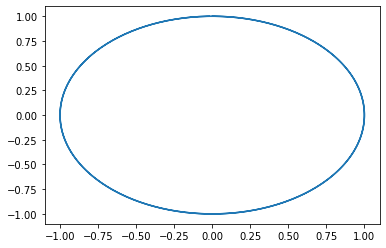

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
#figure(figsize=(8,8), dpi=80)

max_value=12
sin_time=np.sin(2*np.pi*regression_label/12)
cos_time=np.cos(2*np.pi*regression_label/12)
print(sin_time)
print(cos_time)
#df=pd.DataFrame()

#df['sin_value']=sin_time
#df['cos_value']=cos_time
#df.sample(18000).plot.scatter('sin_value','cos_value').set_aspect('equal')
plt.plot(sin_time,cos_time)
y_labels=[]

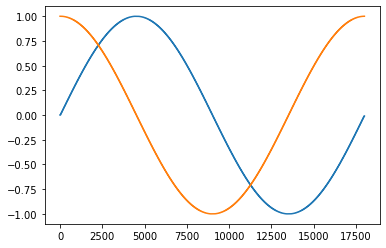

In [ ]:
cyclic_labels=[]
for i in range(len(labels)):
  entry=[]
  entry.append(np.sin(2*np.pi*regression_label[i]/12))
  entry.append(np.cos(2*np.pi*regression_label[i]/12))
  cyclic_labels.append(entry)
#print(cyclic_labels)
plt.plot(cyclic_labels)

In [ ]:
from functools import partial
DefaultConv2D = partial(keras.layers.Conv2D,
  kernel_size=3, activation='relu', padding="SAME")
model = keras.models.Sequential([
  DefaultConv2D(filters=32, kernel_size=7, input_shape=[150, 150, 1]),
  keras.layers.MaxPooling2D(pool_size=2),
  DefaultConv2D(filters=16),
  DefaultConv2D(filters=16),
  keras.layers.MaxPooling2D(pool_size=2),
  keras.layers.Flatten(),
  keras.layers.Dense(units=8, activation='relu'),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(units=2, activation='softmax'),  
  ])
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(learning_rate=0.001), metrics=['accuracy'])

from tensorflow.keras import utils as np_utils

X_train_full, X_test, y_train_full_classification, y_test_classification = train_test_split(images, cyclic_labels, test_size=0.20, random_state=42)
X_valid, X_train = X_train_full[:4000], X_train_full[4000:]
y_valid_classification, y_train_classification = y_train_full_classification[:4000], y_train_full_classification[4000:]
#print(y_train, y_test)

X_train = X_train.reshape((X_train.shape[0], 150, 150, 1))
X_test = X_test.reshape((X_test.shape[0], 150, 150, 1))
X_valid = X_valid.reshape((X_valid.shape[0], 150, 150, 1))
print(len(y_train_classification),len(y_test_classification))

y_train_classification = np_utils.to_categorical(y_train_classification)
y_test_classification = np_utils.to_categorical(y_test_classification)
y_valid_classification = np_utils.to_categorical(y_valid_classification)

10400 3600


In [ ]:
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Input, Model
from functools import partial


DefaultConv2D = partial(keras.layers.Conv2D,
  kernel_size=3, activation='relu', padding="SAME")

X=images
y=labels

X = X.reshape(-1, 150, 150, 1)
print(X.shape)

y_sine = sin_time
#for i in y:
#  y_hour.append(i[0])
#y_hour = np.array(y_hour)
#y_hour = np_utils.to_categorical(y_hour)

y_cos = cos_time
#for i in y:
#  y_minute.append(i[1])
#y_minute = np.array(y_minute)

X_train, X_test, y_train_sine, y_test_sine = train_test_split(X, y_sine, test_size=0.2)
X_train, X_test, y_train_cos, y_test_cos = train_test_split(X, y_cos, test_size=0.2)

print("X", X.shape)
print("y_hour", y_sine.shape)
print("y_minute", y_cos.shape)

#del multi_head_model

inputs = Input(shape=(150, 150,1), name='input')
x = DefaultConv2D(filters=16, kernel_size=3, name='16')(inputs)
print('sghsb')
x = DefaultConv2D(filters=32, name='32')(x)
x = DefaultConv2D(filters=64, name='64')(x)
x = DefaultConv2D(filters=128, name='128')(x)
x = Flatten()(x)
output1 = Dense(1, name='sine_out')(x)
output2 = Dense(1, name='cos_out')(x)

multi_head_model = Model(inputs=inputs, outputs=[output1, output2])

multi_head_model.compile(loss={'sine_out': 'mae', 
                    'cos_out': 'mae'},
              optimizer='adam')
              #metrics={'hour_out': tf.metrics.SparseCategoricalAccuracy(name='acc')})

multi_head_model.fit(X_train, {'sine_out': y_train_sine, 'cos_out': y_train_cos},
                     epochs=10, validation_split=0.1)

(18000, 150, 150, 1)
X (18000, 150, 150, 1)
y_hour (18000,)
y_minute (18000,)
sghsb
Epoch 1/10
405/405 [==============================] - 104s 255ms/step - loss: 103.0579 - sine_out_loss: 51.5642 - cos_out_loss: 51.4935 - val_loss: 1.2748 - val_sine_out_loss: 0.6365 - val_cos_out_loss: 0.6383
Epoch 2/10
405/405 [==============================] - 103s 254ms/step - loss: 1.2596 - sine_out_loss: 0.6358 - cos_out_loss: 0.6237 - val_loss: 1.2671 - val_sine_out_loss: 0.6431 - val_cos_out_loss: 0.6240
Epoch 3/10
405/405 [==============================] - 105s 259ms/step - loss: 1.2047 - sine_out_loss: 0.6143 - cos_out_loss: 0.5904 - val_loss: 1.2959 - val_sine_out_loss: 0.6736 - val_cos_out_loss: 0.6223
Epoch 4/10
405/405 [==============================] - 105s 260ms/step - loss: 1.0813 - sine_out_loss: 0.5549 - cos_out_loss: 0.5263 - val_loss: 1.2777 - val_sine_out_loss: 0.6633 - val_cos_out_loss: 0.6144
Epoch 5/10
405/405 [==============================] - 103s 255ms/step - loss: 0.9324 - s